In [1]:
import xml.etree.ElementTree as ET
from lxml import etree
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import datetime
from datetime import timedelta

In [2]:
class apple_health(object):
    def __init__(self, xml_data_path):
        self.tree = etree.parse(xml_data_path)
        self.root = self.tree.getroot()
        self.records = []
        for i, element in enumerate(self.root):
            self.records.append(element.attrib)
        self.r_types = []
        self.analyze_types()
        
    def analyze_types(self):
        for i, record in enumerate(self.records):
            try:
                if record['type'].split('HKQuantityTypeIdentifier')[1] not in self.r_types:
                    self.r_types.append(record['type'].split('HKQuantityTypeIdentifier')[1])
                else:
                    pass
            except:
                pass
        
    def extract_type(self, r_type):
        self.r_type_list = []
        for i, record in enumerate(self.records):
            try:
                if record['type'] == r_type:
                    self.r_type_list.append(record)
            except:
                pass
        self.r_type_list_ = [dict(record) for record in self.r_type_list]
        
        df = pd.DataFrame(self.r_type_list_, columns = self.r_type_list_[0].keys())
        time_col = ['startDate','endDate']
        for col in time_col:
            df[col] = pd.to_datetime(df[col])
        try:
            df['value'] = df['value'].astype(float)
        except:
            pass
        return df

In [3]:
def format_dates(df):
    df['date'] = df['startDate'].map(lambda x: x.date())
    sub_df = df.groupby('date').sum().reset_index()
    sub_df['month'] = sub_df['date'].map(lambda x: x.month)
    sub_df['year'] = sub_df['date'].map(lambda x: x.year)
    sub_df['day_of_month'] = sub_df['date'].map(lambda x: x.day)
    return sub_df

In [4]:
xml_data = '/Users/ryand/pyprojects/Data/apple_health_export 2/export.xml'
my_data = apple_health(xml_data)
my_data.r_types

['Height',
 'BodyMass',
 'HeartRate',
 'StepCount',
 'DistanceWalkingRunning',
 'BasalEnergyBurned',
 'ActiveEnergyBurned',
 'FlightsClimbed',
 'NikeFuel',
 'AppleExerciseTime',
 'VO2Max',
 'HeartRateVariabilitySDNN']

In [5]:
df_ET = my_data.extract_type('HKQuantityTypeIdentifierAppleExerciseTime')
df_HR = my_data.extract_type('HKQuantityTypeIdentifierHeartRate')
df_SC = my_data.extract_type('HKQuantityTypeIdentifierStepCount')
df_AE = my_data.extract_type('HKQuantityTypeIdentifierActiveEnergyBurned')
df_BE = my_data.extract_type('HKQuantityTypeIdentifierBasalEnergyBurned')

# Basal Energy

In [6]:
df_BE['startDate_local'] = df_BE['startDate'].map(lambda x: x - timedelta(hours=7))
df_BE['date'] = df_BE['startDate'].map(lambda x: x.date())

In [8]:
# df_BE.groupby('date').sum()

In [9]:
df_AE['startDate_local'] = df_AE['startDate'].map(lambda x: x - timedelta(hours=7))
df_AE['date'] = df_AE['startDate'].map(lambda x: x.date())

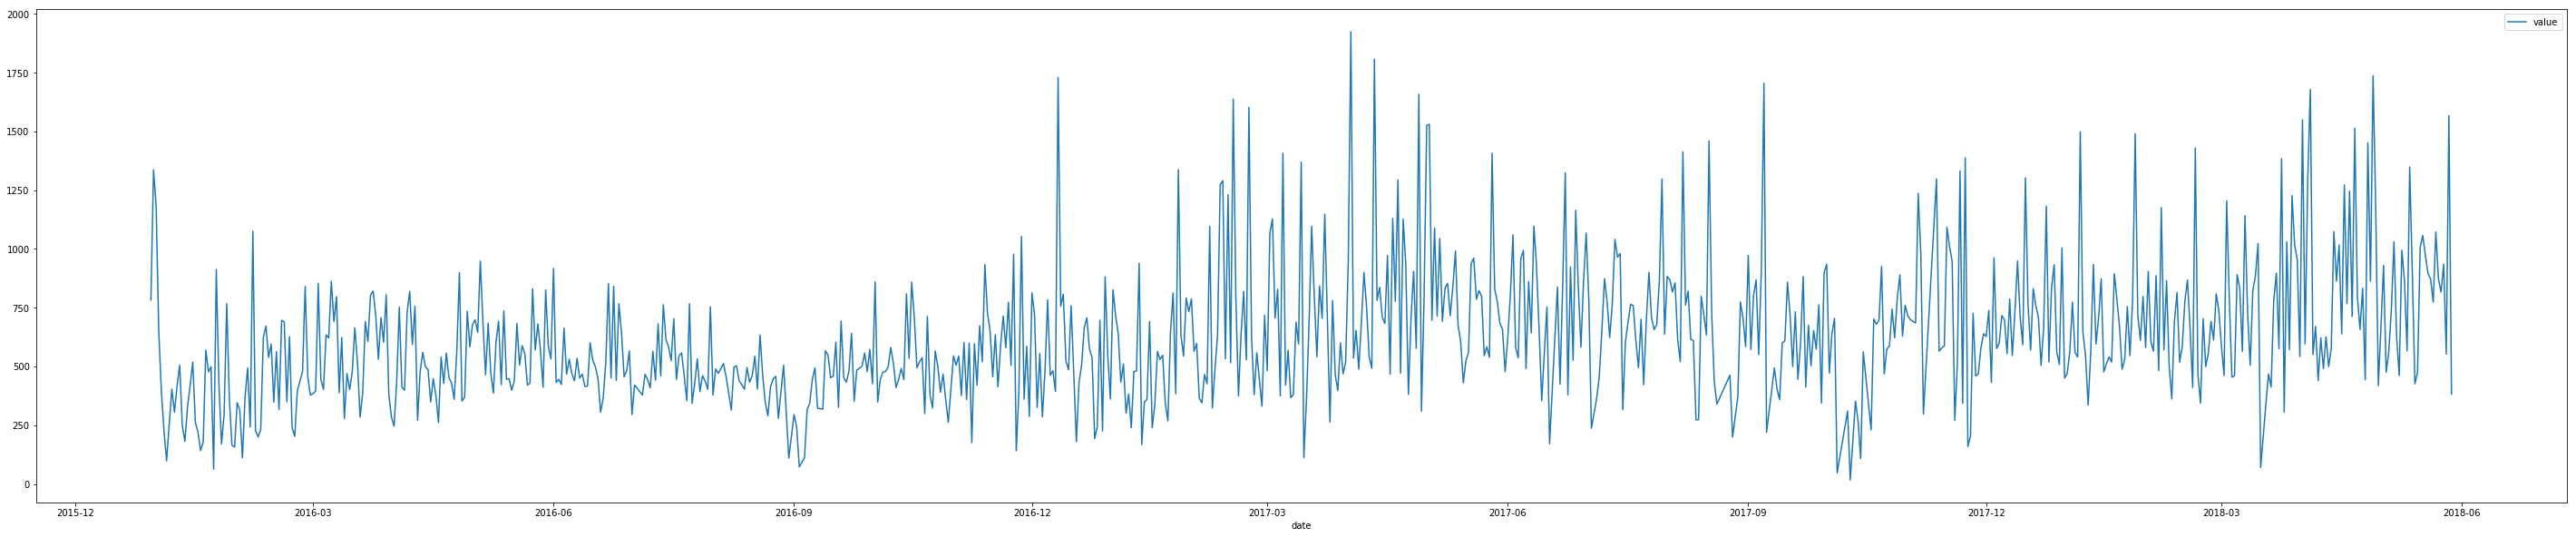

In [10]:
df_AE.groupby('date').sum().plot(figsize=(50,10))

# Analizing steps

In [34]:
watch_SC = df_SC[df_SC['sourceName'] == df_SC.groupby('sourceName').sum().index[2]].reset_index(inplace=False)
del watch_SC['index']
Haley_SC = df_SC[df_SC['sourceName'] == 'Haley'].reset_index(inplace=False)
del Haley_SC['index']

In [35]:
for i, startDate in enumerate(watch_SC['startDate']):
    try:
        endDate = watch_SC.loc[i-1, 'endDate']
        between = Haley_S[(Haley_SC['startDate'] > endDate)
                              & (Haley_SC['endDate'] < startDate)]
        if len(between) > 0:
            watch_SC = watch_SC.append(between)
    except:
        pass

In [36]:
watch_SC['cc'] = 1
watch_SC.groupby('sourceName').sum()[['cc']]

cc
sourceName                
Ryan’s Apple Watch  128195

In [37]:
df = watch_SC

In [38]:
df['startDate_local'] = df['startDate'].map(lambda x: x - timedelta(hours=7))
df['date'] = df['startDate_local'].map(lambda x: x.date())

In [39]:
_SC = df.groupby('date').sum()[['value']].rename(columns={'value':'steps'})

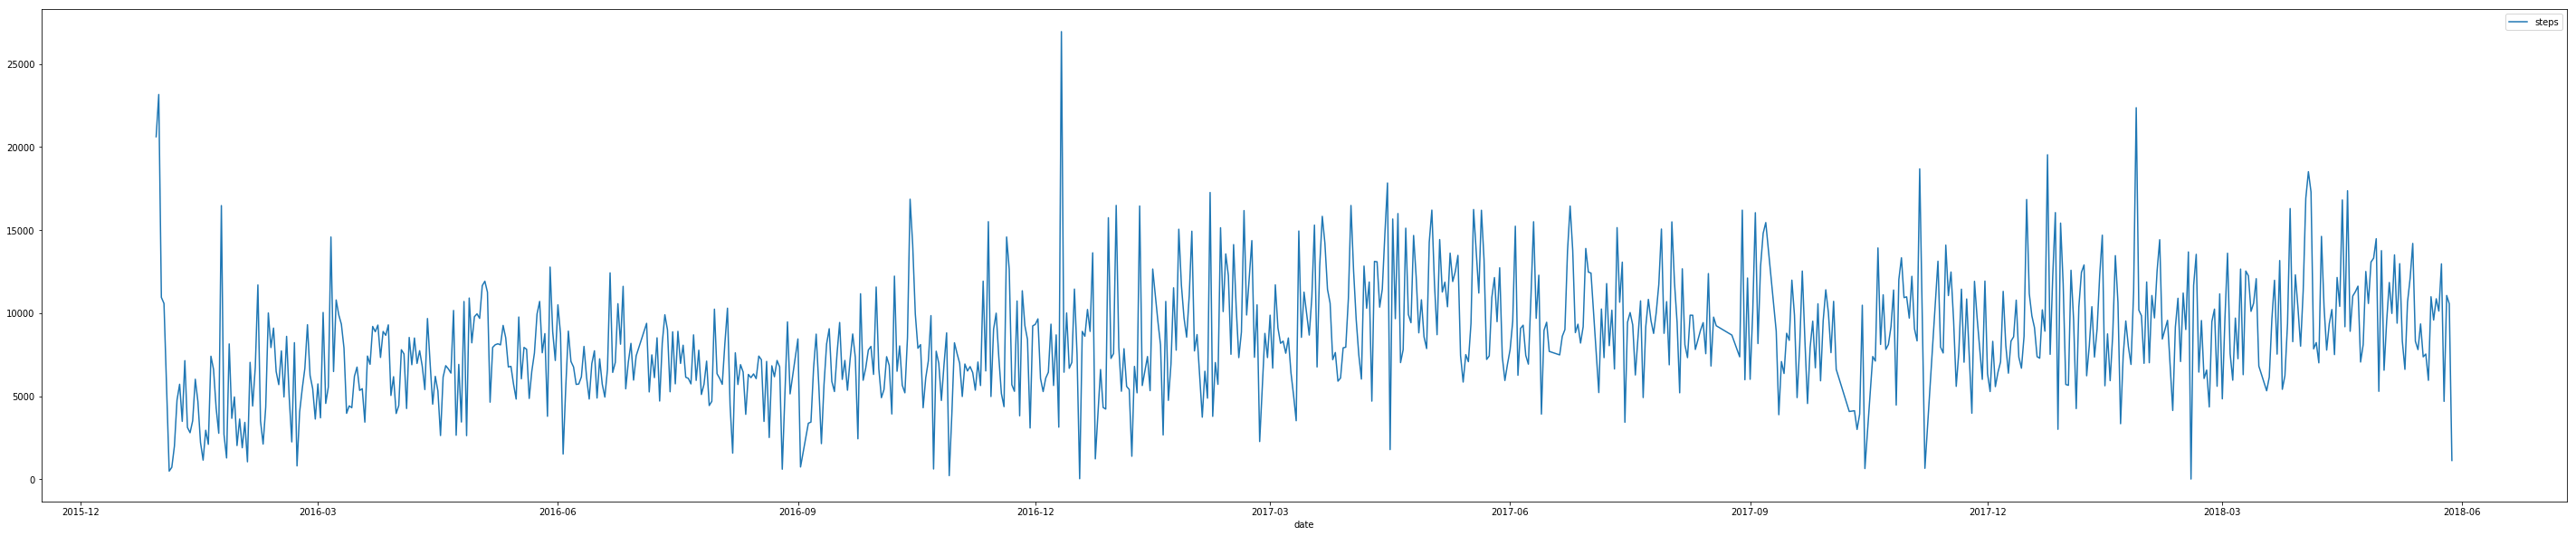

In [40]:
_SC.plot(figsize=(50,10))

# Analizing Heart Rate

In [41]:
df_HR['startDate_local'] = df_HR['startDate'].map(lambda x: x - timedelta(hours=7))
df_HR['date'] = df_HR['startDate_local'].map(lambda x: x.date())

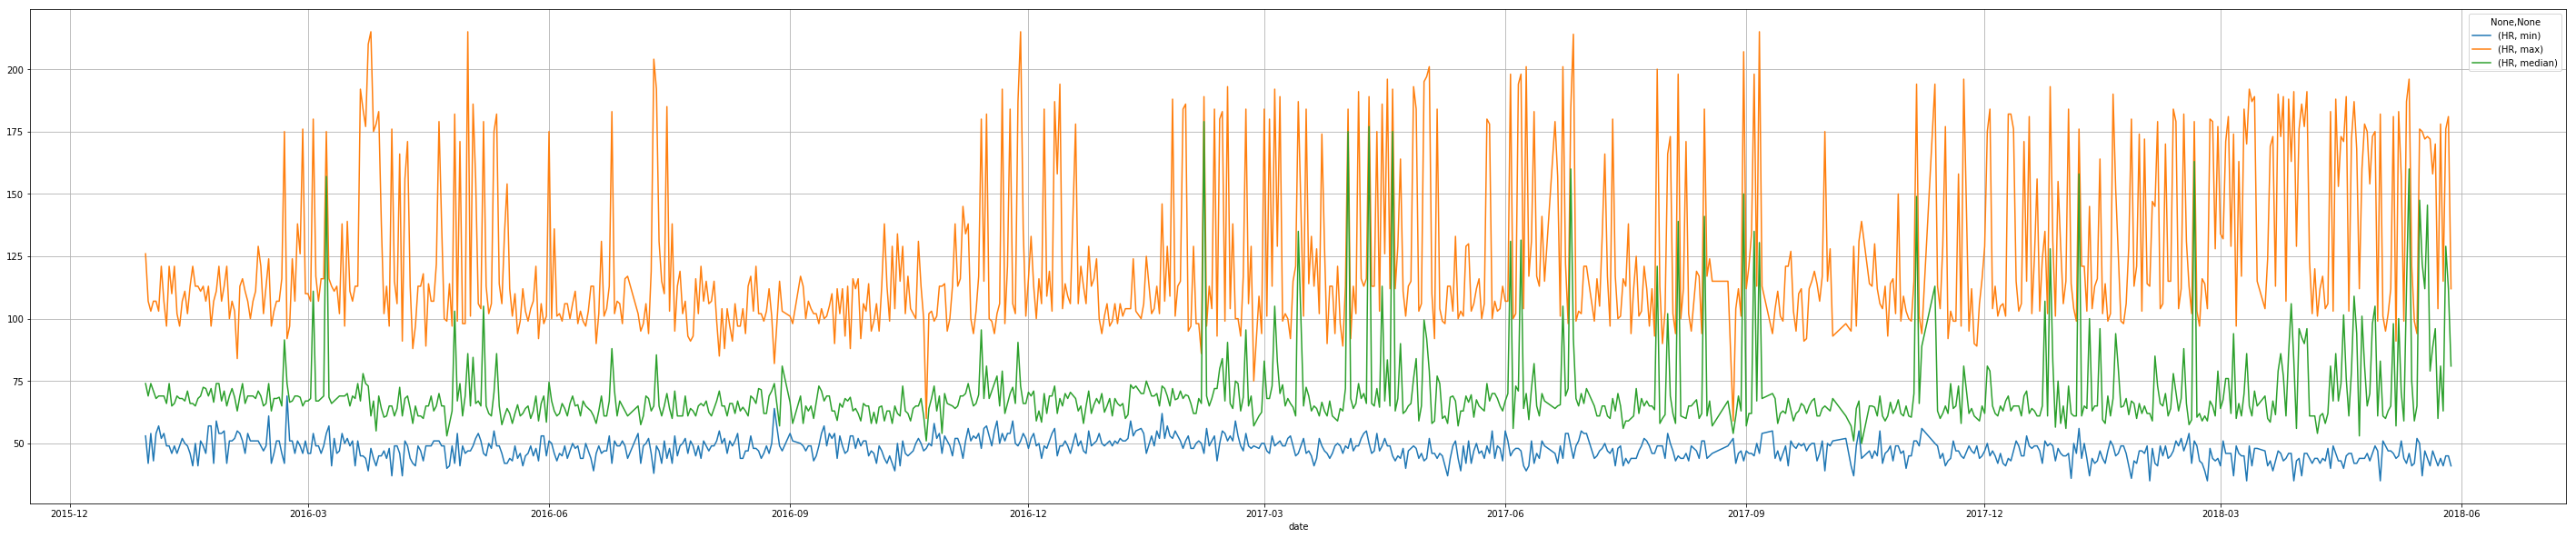

In [42]:
_HR = df_HR.groupby('date').agg({'value':['min','max','median']}).rename(columns={'value':'HR'})
_HR.plot(figsize=(50,10), grid=True)

In [43]:
high_med = df_HR[df_HR['date'].isin(_HR.sort_values(('HR','median'),ascending=False).head(18).index.tolist())].copy()
low_med = df_HR[df_HR['date'].isin(_HR.sort_values(('HR','median'),ascending=False).head(200).index.tolist())].copy()

In [44]:
high_med['med_type'] = 'high'
low_med['med_type'] = 'low'

In [45]:
med_ = high_med.append(low_med)

In [46]:
med_.groupby(['med_type']).describe()

value                                                         
            count        mean        std   min    25%    50%    75%    max
med_type                                                                  
high       8889.0  135.403195  43.424496  43.0  101.0  153.0  171.0  207.0
low       58695.0  102.121203  40.305032  35.0   69.0   90.0  132.0  215.0

In [47]:
high_med['hour'] = high_med['startDate'].apply(lambda x: x.hour)
high_med['minute'] = high_med['startDate'].apply(lambda x: x.minute)

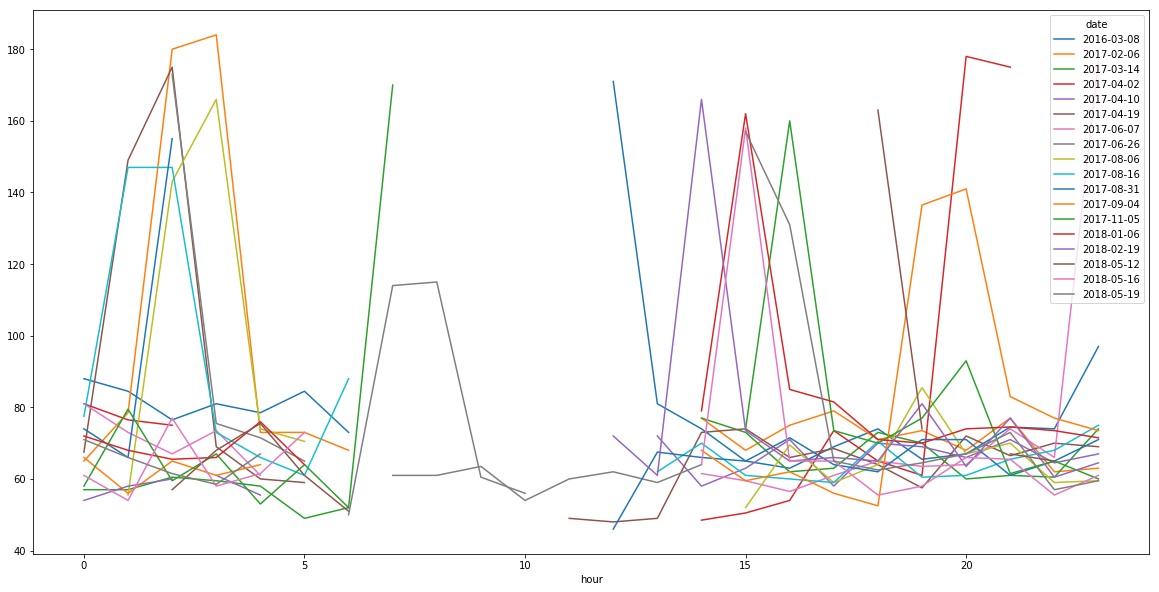

In [48]:
high_med.groupby(['date','hour']).median()['value'].unstack(level=1).T.plot(figsize = (20,10))

* It's possible that there is simply more sampling during high exercise times. Plots to test following this

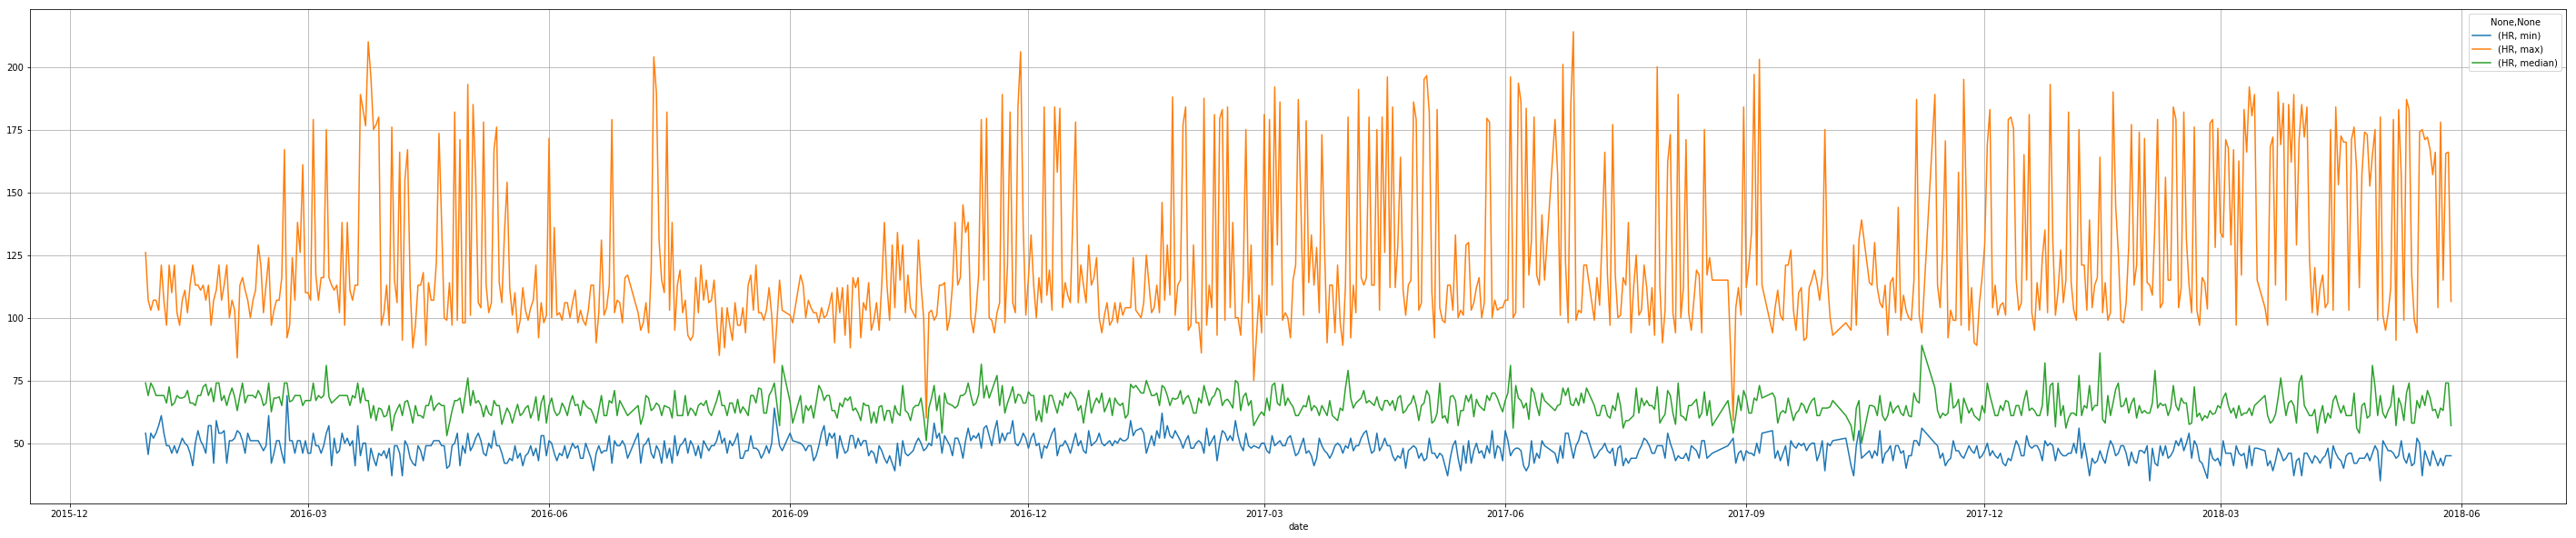

In [49]:
df_HR['hour'] = df_HR['startDate'].apply(lambda x: x.hour)
df_HR['minute'] = df_HR['startDate'].apply(lambda x: x.minute)
_HR_resample = df_HR.groupby(['date','hour','minute']).median().reset_index()
_HR_resample_ = _HR_resample.groupby('date').agg({'value':['min','max','median']}).rename(columns={'value':'HR'})
_HR_resample_.plot(figsize=(50,10), grid=True)

In [50]:
wk = _HR_resample_.tail(50).copy()

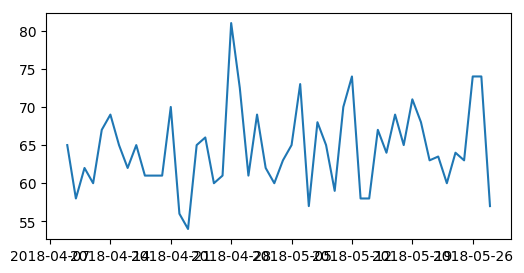

In [51]:
fig, ax1 = plt.subplots(dpi = 100, figsize=(6,3))
ax1.plot(wk.index, wk[('HR','median')])

In [52]:
_HR_resample['wkday'] = _HR_resample['date'].apply(lambda x: x.weekday())

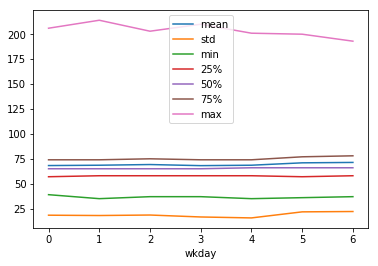

In [53]:
_HR_resample.groupby('wkday').describe()['value'][['mean', 'std', 'min', '25%', '50%', '75%', 'max']].plot()

In [54]:
z_min = np.polyfit(_HR.reset_index().index,_HR[('HR','min')],50)
p_min = np.poly1d(z_min)
z_max = np.polyfit(_HR.reset_index().index,_HR[('HR','max')],50)
p_max = np.poly1d(z_max)

/Users/ryand/envs/virt1/lib/python2.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.
/Users/ryand/envs/virt1/lib/python2.7/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
len(_HR)

839

In [56]:
trend = np.linspace(0,767,767)

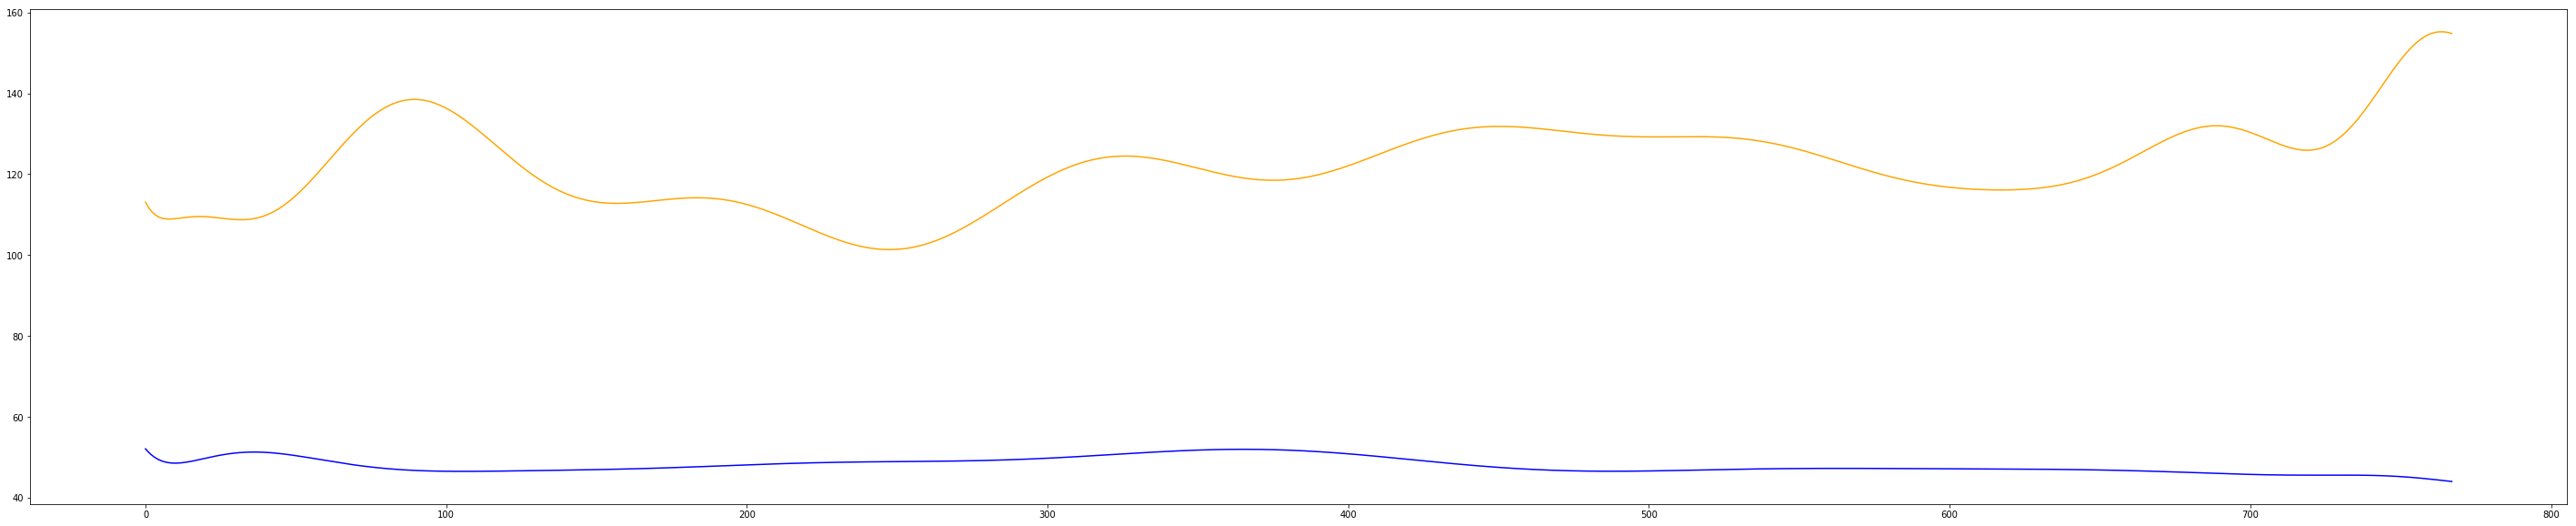

In [57]:
fig, ax = plt.subplots(figsize=(50,10))
ax.plot(trend, p_min(trend), color='blue', label='min')
ax.plot(trend, p_max(trend), color='orange', label='max')

In [58]:
_HR = df_HR.groupby('date').agg({'value':'describe'})[[('value','25%'),('value','75%')]].rename(columns={'value':'HR'})

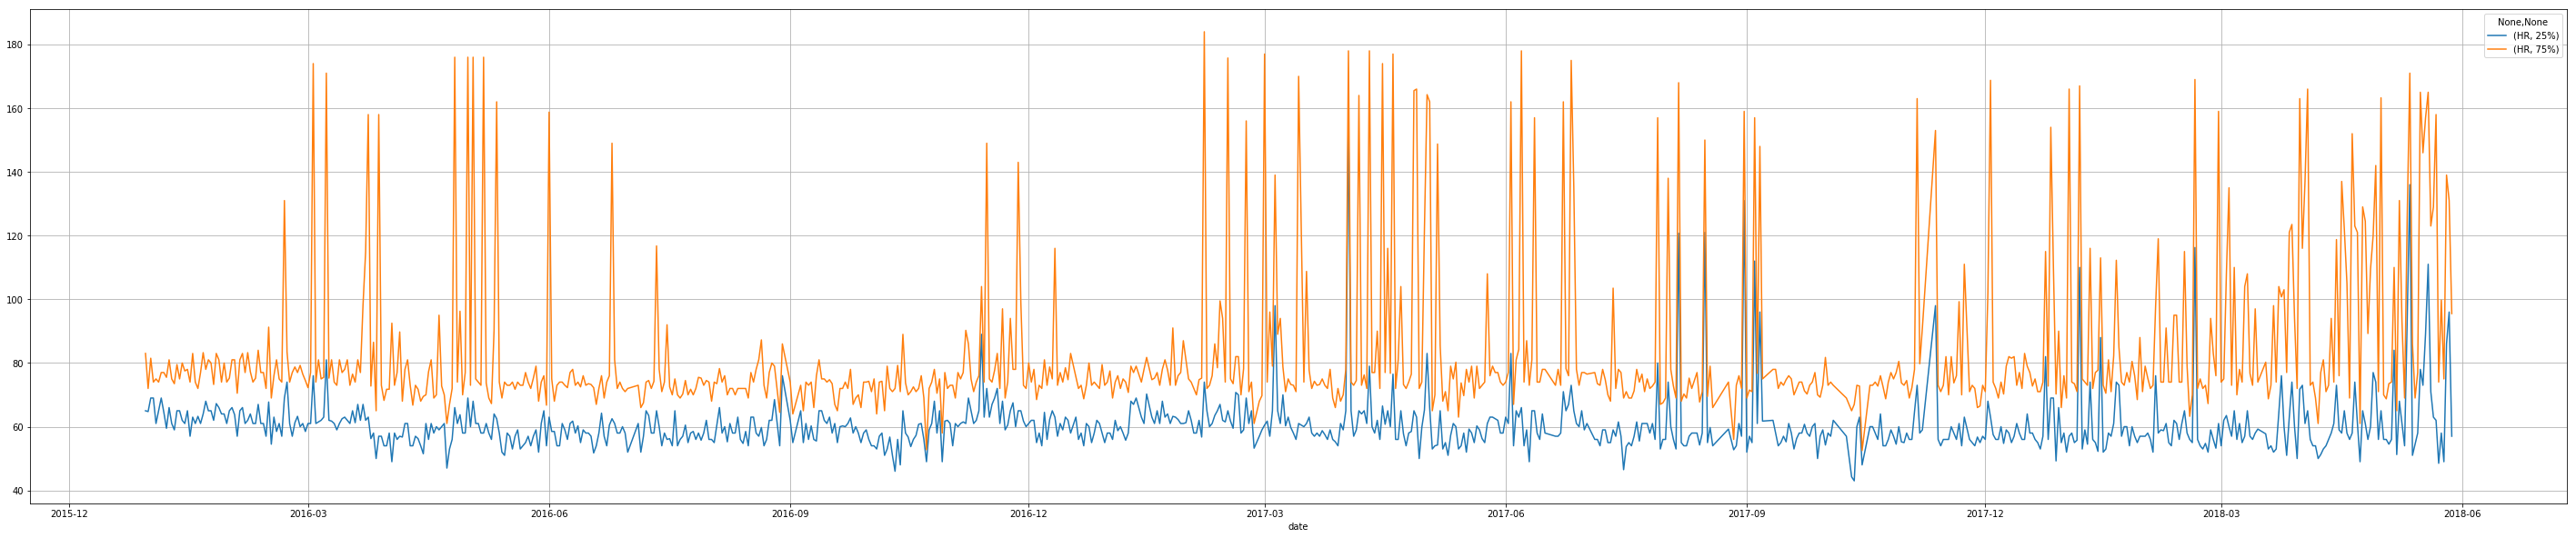

In [59]:
_HR.plot(figsize=(50,10), grid=True)

# Steps + Heart Rate

/Users/ryand/envs/virt1/lib/python2.7/site-packages/pandas/core/reshape/merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


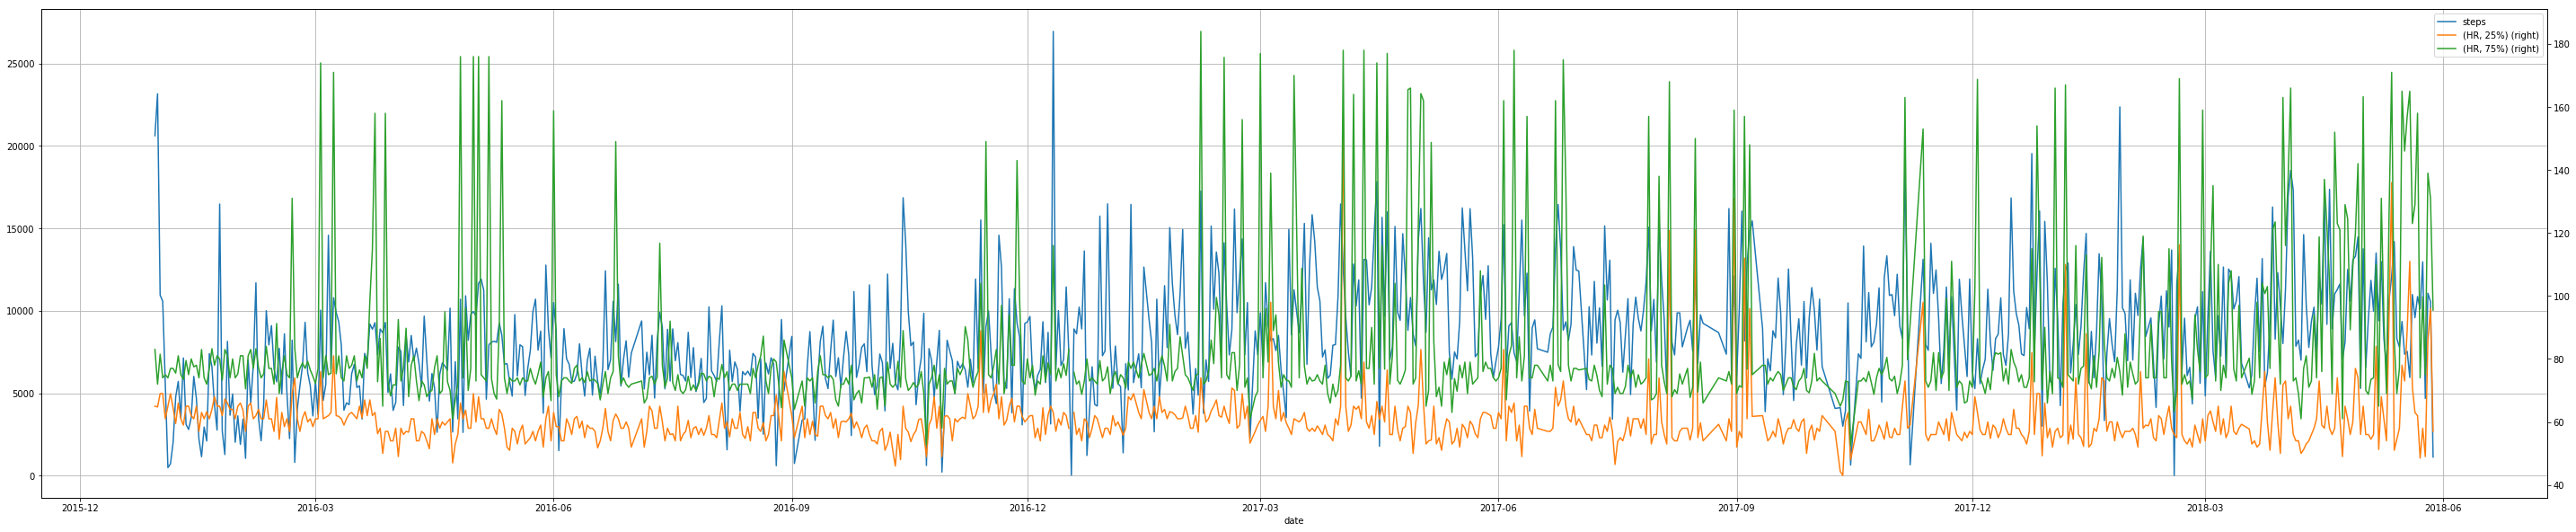

In [60]:
_SC.join(_HR).plot(figsize=(50,10), secondary_y=[('HR','25%'),('HR','75%')], grid=True)

# Sleep

In [62]:
for x in ['startDate','endDate']:
    df_S['{x}_local'.format(x=x)] = df_S['{x}'.format(x=x)].map(lambda x: x - timedelta(hours=7))

NameError: name 'df_S' is not defined

In [51]:
# df_S = df_S[df_S['sourceName'] == 'Clock']
df_S = df_S.sort_values('startDate_local')
df_S = df_S.reset_index()
del df_S['index']

In [52]:
for x in range(20):
    count = 0
    for i, startDate in enumerate(df_S['startDate_local']):
        try:
            endDate = df_S.loc[i-1, 'endDate_local']
            if (startDate - timedelta(minutes=30)) < endDate:
                new_endDate = df_S.loc[i, 'endDate_local']
                df_S.loc[i-1, 'endDate_local'] = new_endDate
                df_S.loc[i, 'drop'] = True
                count += 1
        except:
            pass
    print(f'Pass {x} with {count}')
    count = 0
df_S = df_S[df_S['drop'] != True]
del df_S['drop']

Pass 0 with 460
Pass 1 with 460
Pass 2 with 460
Pass 3 with 460
Pass 4 with 460
Pass 5 with 460
Pass 6 with 460
Pass 7 with 460
Pass 8 with 460
Pass 9 with 460
Pass 10 with 460
Pass 11 with 460
Pass 12 with 460
Pass 13 with 460
Pass 14 with 460
Pass 15 with 460
Pass 16 with 460
Pass 17 with 460
Pass 18 with 460
Pass 19 with 460


In [53]:
df_S['duration'] = (df_S['endDate_local'] - df_S['startDate_local']).map(lambda x: x.seconds/3600)


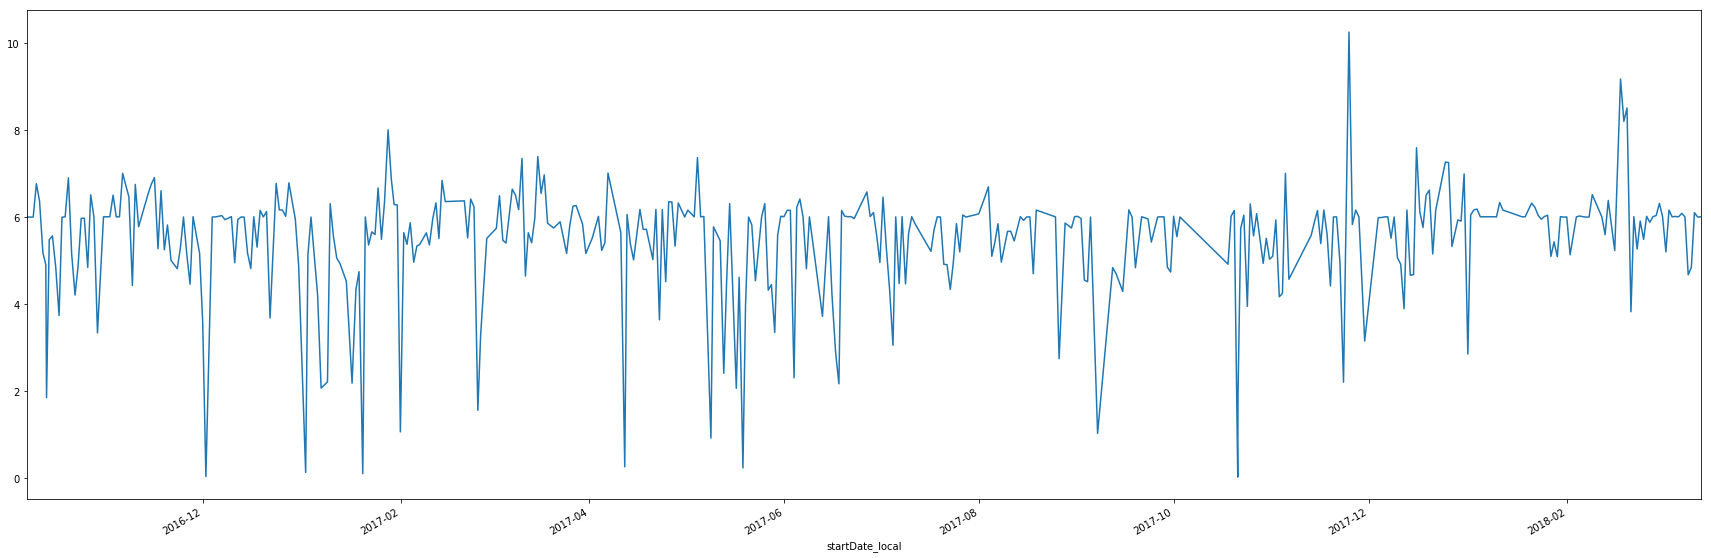

In [54]:
df_S = df_S.set_index('startDate_local')
df_S['duration'].plot(figsize=(30,10))

# Active Energy Burned

In [63]:
df_AE['startDate_local'] = df_AE['startDate'].map(lambda x: x - timedelta(hours=7))
df_AE['date'] = df_AE['startDate_local'].map(lambda x: x.date())

In [64]:
df_AE_ = df_AE.groupby('date').sum()

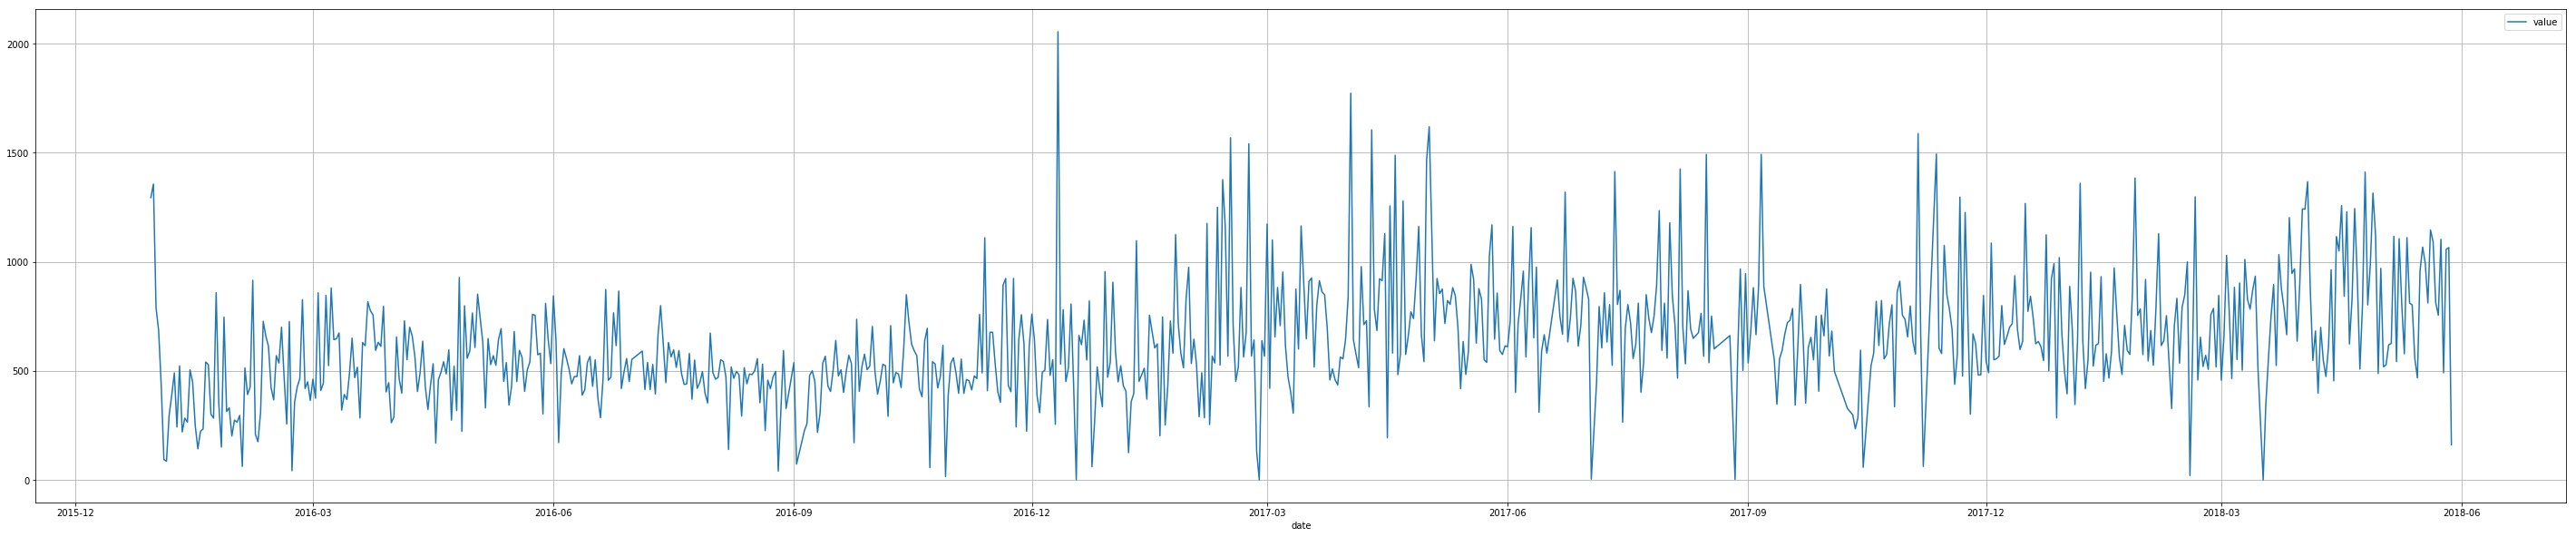

In [65]:
df_AE_.plot(figsize=(50,10), grid=True)

In [66]:
z_a = np.polyfit(df_AE_.reset_index().index,df_AE_[('value')],17)
p_a = np.poly1d(z_a)

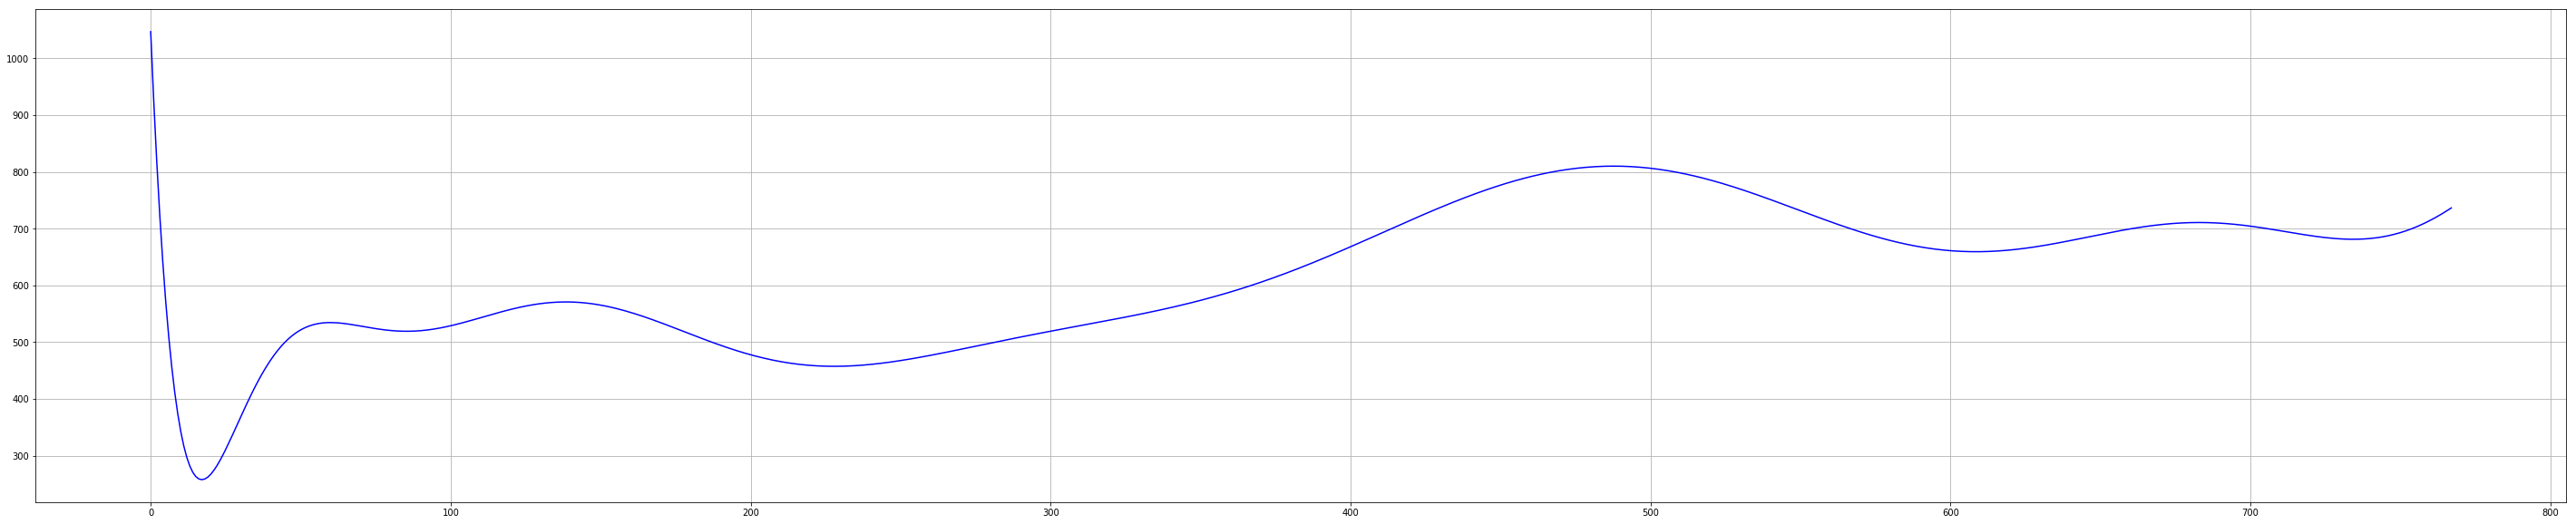

In [67]:
fig, ax = plt.subplots(figsize=(50,10))
ax.grid(True)
ax.plot(trend, p_a(trend), color='blue', label='min')

# Merge df's

In [70]:
# df_ET['ExerciseTime']

In [71]:
df_HR.columns.tolist()

['startDate',
 'endDate',
 'sourceName',
 'value',
 'sourceVersion',
 'device',
 'creationDate',
 'type',
 'unit',
 'startDate_local',
 'date',
 'hour',
 'minute']

In [72]:
append_cols = ['type','sourceName','unit','startDate','endDate','value']

In [73]:
final = df_ET[append_cols].append(
                df_HR[append_cols]
            ).append(df_SC[append_cols]
            ).append(df_AE[append_cols]
            ).append(df_BE[append_cols]
            )

In [74]:
len(set(final['startDate']))

1231458

In [75]:
final['startDate'][0].tolist()[0].minute

22

In [76]:
final['year'] = final['startDate'].apply(lambda x: x.year)
final['month'] = final['startDate'].apply(lambda x: x.month)
final['day'] = final['startDate'].apply(lambda x: x.day)
final['hour'] = final['startDate'].apply(lambda x: x.hour)
final['minute'] = final['startDate'].apply(lambda x: x.minute)
final['second'] = final['startDate'].apply(lambda x: x.second)

In [77]:
final_ = final.groupby(['year','month','day','type']).sum()[['value']].unstack(level=-1)

In [78]:
final_.columns = ['HKQuantityTypeIdentifierActiveEnergyBurned', 'HKQuantityTypeIdentifierAppleExerciseTime', 'HKQuantityTypeIdentifierBasalEnergyBurned', 'HKQuantityTypeIdentifierHeartRate', 'HKQuantityTypeIdentifierStepCount']

In [79]:
def make_index(index):
    new_index = []
    for row in index:
        row_ = []
        for bit in row:
            row_.append(str(bit))
        new_index.append('-'.join(row_))
    return new_index

In [80]:
new_index = make_index(final_.index)

In [81]:
final_.index = new_index

In [82]:
final_['TotalEnergyBurned'] = final_['HKQuantityTypeIdentifierBasalEnergyBurned'] + final_['HKQuantityTypeIdentifierActiveEnergyBurned'].fillna(0)

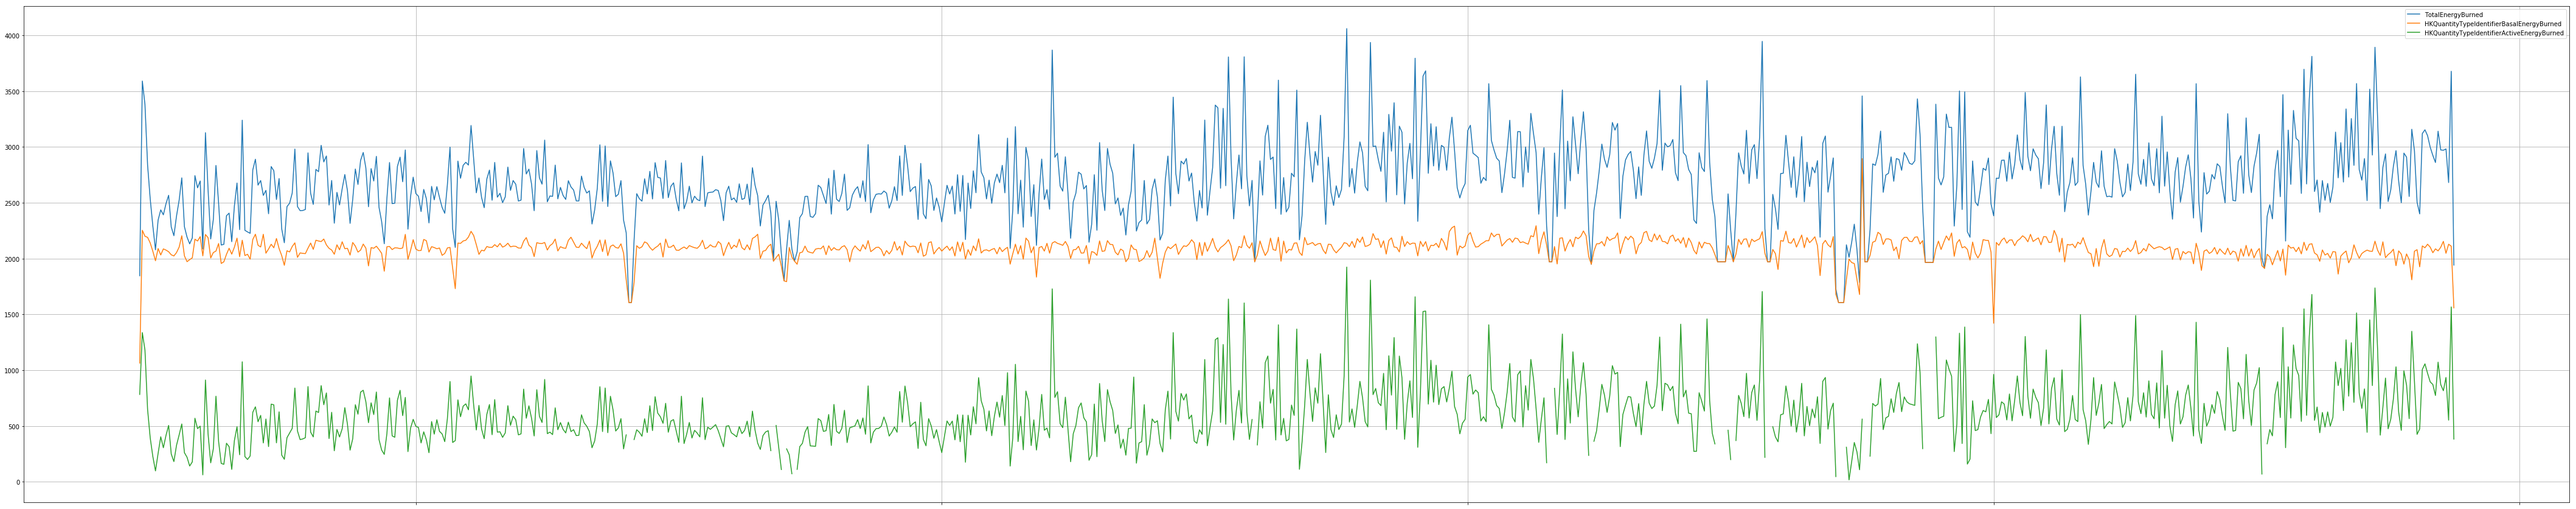

In [83]:
final_[['TotalEnergyBurned','HKQuantityTypeIdentifierBasalEnergyBurned','HKQuantityTypeIdentifierActiveEnergyBurned']].plot(figsize=(75,15), grid=True)

In [112]:
final_['year'] = pd.to_datetime(final_.index)

In [113]:
final_['week'] = final_['year'].apply(lambda dt_: str(dt_.isocalendar()[1]))
final_['year'] = final_['year'].apply(lambda dt_: str(dt_.year))

In [114]:
final_['timeframe'] = final_['year'] + '+' + final_['week']

In [117]:
final_['% active'] = final_['HKQuantityTypeIdentifierActiveEnergyBurned']/final_['TotalEnergyBurned']

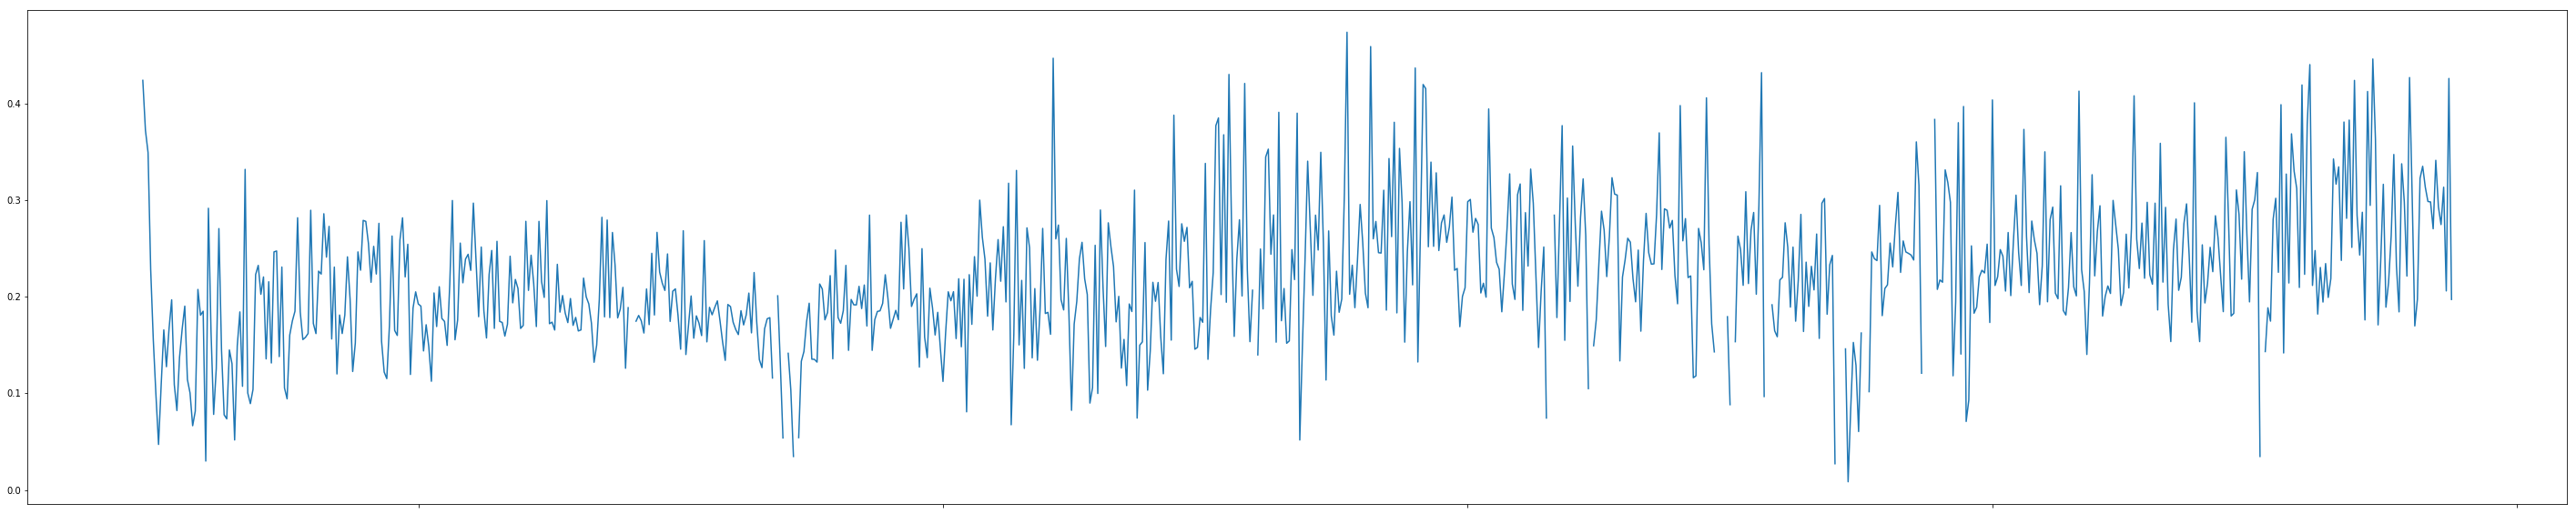

In [118]:
final_['% active'].plot(figsize=(50,10))